## Importing modules

In [268]:
from ase.io import read, write
from ase.visualize import view
from ase.build.molecule import molecule
from ase.io import write
from ase.io.pov import get_bondpairs, set_high_bondorder_pairs
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
import os
import numpy as np
import copy as cp
from matplotlib import pyplot as plt
from ase import Atoms
from ase.io import write
import random
from ase.constraints import FixAtoms
from ase.optimize import BFGS
from ase.build import molecule
from ase.neighborlist import NeighborList

## Functions

In [166]:
def get_components(c0, c1):
    '''Parameters:
        - c0: list of Cartesian coordinates for neighboring atom
        - c1: list of Cartesian coordinates for atom to be replaced 
        Returns:
        -  x, y, z components of vector between both sets of coordinates'''
    return (c1[0]-c0[0], c1[1]-c0[1], c1[2]-c0[2])

def plane_equation(p1, p2, p3): # this is apparently wrong
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p3) - np.array(p1)
    equation = np.cross(v1, v2)
    # equation = np.cross(v1, v2) / np.gcd.reduce(np.cross(v1, v2))
    equation = np.append(equation, np.dot(equation, p3))
    return equation

def get_angle(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))

import math

def get_init_coords(length, x_fin, y_fin, z_fin):
    # Calculate the initial coordinates
    # Assuming the vector's initial coordinates are (x_initial, y_initial, z_initial)
    x_init = x_fin - length * math.cos(math.atan2(y_fin, x_fin))
    y_init = y_fin - length * math.sin(math.atan2(y_fin, x_fin))
    z_init = z_fin  # For 2D vectors, set z_initial to 0

    return (x_init, y_init, z_init)

def make_perpendicular(v1, v2):
    # Calculate the perpendicular vector v3
    v3 = np.cross(v1, v2)
    # Normalize v3 to make it a unit vector
    v3 = v3 / np.linalg.norm(v3)
    # Rotate v2 by 90 degrees using the cross product with v3
    v2_rotated = np.cross(v3, v2)
    return v2_rotated

def get_plane_angle(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.abs(np.degrees(np.arcsin(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))))


def attach_ligand(attach_site, ligand, replace_coordinates, ligand_center_direction, C_lig_direction, plane_ortho_vec, rotation_vec_to_plane, ligand_attach_index):
    ligand.rotate(ligand_center_direction, C_lig_direction)
    sigma = get_plane_angle(plane_ortho_vec, rotation_vec_to_plane)
    if sigma < 90:
        sigma = 180 - sigma
    ligand.rotate(sigma, C_lig_direction)
    T = get_components(ligand.get_positions()[ligand_attach_index], replace_coordinates)
    ligand.translate(T)
    attach_site.extend(ligand)

## add glucose to glu3_rtr unrefined

In [259]:
path = "/Users/adrianaladera/Desktop/MIT/research/MOChAs/original_structures/glu3_rtr/"
glu_unrefined = read(f"{path}POSCAR")
glu_skel = read(f"{path}glu3_skel_rtr.vasp")
glu_final = read(f"{path}glu3_final.vasp")
glucose = read(f"{path}glucose.vasp")

glucose.pop(2) # pop O
glucose.pop(19) # pop H
print(glucose.get_chemical_symbols())

# for atom in range(len(glucose)):
#     if glucose.get_chemical_symbols()[atom] =='C':
#         print(atom)

# glucose.pop(5)

# plane indices for glucose: 1-O, 9-C,11-Ch
        
view(glucose, viewer='x3d')

['O', 'O', 'O', 'O', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']


In [159]:
glucose.rotate('y', -15)
glucose.rotate('x', 20)
# view(glucose, viewer='x3d')

In [273]:
print(random.randint(-15, 15))

0


# attach hydrogens to sites


In [275]:
from ase.neighborlist import NeighborList
import math as meth
import numpy as np

path = "/Users/adrianaladera/Desktop/MIT/research/MOChAs/original_structures/glu3_rtr/"
glu_unrefined = read(f"{path}glu3-rtr_unrefined.vasp")
glu_final = read(f"{path}glu3-rtr_unrefined.vasp")

# for g in range(len(glu_unrefined)):
    # print(glu_unrefined.get_chemical_symbols()[g], glu_unrefined.get_positions()[g])

# O_indices = np.array([47,54,46,44,52,45,53,55])
O_indices = np.array([19,22,18,16,20,17,23,21])
skip_pos = []
for o in O_indices:
    skip_pos.append(glu_unrefined.get_positions()[o])

O1 = []
for o in range(len(glu_unrefined)):
    if glu_unrefined.get_chemical_symbols()[o] == 'O' and o not in O_indices:
        O1.append(o)


for i in range(len(O1)):
    H_root = get_init_coords(0.973, 1,1,0)
    H2 = Atoms('H2', positions=[H_root, [1,1,0]])
    H_vec = get_components(H2.get_positions()[0], H2.get_positions()[1])
    H2.rotate(random.randint(-45, 45), H_vec)
    T = get_components(H2.get_positions()[0], glu_unrefined.get_positions()[O1[i]])
    H2.translate(T)
    H2.pop(0)
        
    glu_final.extend(H2)

write(f"{path}glu3-rtr_refined.vasp", glu_final)

## attach hydrogens to O sites at 90 angles

In [265]:
from ase.neighborlist import NeighborList
import math as meth
import numpy as np

path = "/Users/adrianaladera/Desktop/MIT/research/MOChAs/original_structures/glu3_rtr/"
glu_unrefined = read(f"{path}POSCAR")
glu_final = read(f"{path}POSCAR")

# for g in range(len(glu_unrefined)):
    # print(glu_unrefined.get_chemical_symbols()[g], glu_unrefined.get_positions()[g])

# O_indices = np.array([47,54,46,44,52,45,53,55])
O_indices = np.array([19,22,18,16,20,17,23,21])
O_other = [35,39,]
C0 = [105,101,69,65,64,68,100,104,80,76,96,88,78,74,94,86,102,98,66,62,79,75,95,87,103,99,67,63,89,97,77,81]
O1 = [55,31,35,39,38,34,30,54,26,42,50,46,24,40,48,44,52,28,32,36,25,41,49,45,53,29,33,37,47,51,43,27]

print(len(C0), len(O1))

# cutoffs = []
# O = []
# u_vecs, v_vecs = [], []
# for atom in range(len(glu_unrefined)):
#     if glu_unrefined.get_chemical_symbols()[atom] == 'O' and atom not in O_indices:
#         O.append(atom)
#         cutoffs.append(1.6)
#     else:
#         cutoffs.append(0.00001)

# nl = NeighborList(cutoffs)
# nl.update(glu_unrefined)

# C0 = []
# O1 = []
# for atom in range(len(O)):
#     # print(atom, nl.get_neighbors(O1[atom])[0], [glu_unrefined.get_chemical_symbols()[n] for n in nl.get_neighbors(O1[atom])[0]])
#     for n in nl.get_neighbors(O[atom])[0]:
#         print(atom, glu_unrefined.get_chemical_symbols()[n])
#         if glu_unrefined.get_chemical_symbols()[n] == 'C':
#             C0.append(n)
#             O1.append(atom)

# print(len(C0), len(O1))

cunt = 0
for i in range(len(O1)):
    H_root = get_init_coords(0.973, 1,1,0)
    H2 = Atoms('H2', positions=[H_root, [1,1,0]])
    H_vec = get_components(H2.get_positions()[0], H2.get_positions()[1])
    CO_vec = get_components(glu_unrefined.get_positions()[C0[i]], glu_unrefined.get_positions()[O1[i]])
    H_perp = make_perpendicular(CO_vec, H_vec)
    H2.rotate(H_vec, H_perp)
    T = get_components(H2.get_positions()[0], glu_unrefined.get_positions()[O1[i]])
    H2.translate(T)
    H2.pop(0)
    
    glu_final.extend(H2)
    cunt += 1

# fig, ax = plt.subplots(1,6, figsize=(24,8))
# plot_atoms(glu_skel, ax[0], radii=0.5, rotation=('90x,180y,0z'))
# plot_atoms(glu_unrefined, ax[1], radii=0.5, rotation=('90x,180y,0z'))
# plot_atoms(glu_final, ax[2], radii=0.5, rotation=('90x,180y,0z'))
# plot_atoms(glu_skel, ax[3], radii=0.5, rotation=('90x,90y,0z'))
# plot_atoms(glu_unrefined, ax[4], radii=0.5, rotation=('90x,90y,0z'))
# plot_atoms(glu_final, ax[5], radii=0.5, rotation=('90x,90y,0z'))

write(f"{path}glu3-rtr_refined.vasp", glu_final)

32 32


## attach glucose to sites

In [261]:
from ase.neighborlist import NeighborList
import math as meth
import numpy as np
import copy as cp

path = "/Users/adrianaladera/Desktop/MIT/research/MOChAs/original_structures/glu3_rtr/"
glu_unrefined = read(f"{path}glu3-rtr_unrefined.vasp")
glu_skel = read(f"{path}glu3_skel_rtr.vasp")
glu_final = read(f"{path}glu3-rtr_skeleton.vasp")
glucose = read(f"{path}glucose.xyz")

# transfer_positions = np.array([47,54,46,44,52,45,53,55])
# transfer_positions = np.array([85,92,84,83,91,83,99,93])
transfer_positions = []

for atom in range(len(glu_final)):
    if glu_final.get_chemical_symbols()[atom] == 'N':
        transfer_positions.append(glu_final.get_positions()[atom])
        
# plane_indices = np.array([[19,27,63],[22,50,38],[18,26,62],[16,24,60],[20,48,36],[17,25,61],[21,49,37],[23,51,39]])
plane_indices = np.array([[19,65,101],[22,88,76],[18,64,100],[16,62,98],[20,86,74],[17,64,100],[91,87,75],[23,89,77]])

u_vecs, v_vecs = [], []
for atom in range(len(plane_indices)):
    u = plane_equation(glu_unrefined.get_positions()[plane_indices[atom][0]], glu_unrefined.get_positions()[plane_indices[atom][1]], glu_unrefined.get_positions()[plane_indices[atom][2]])
    u_vecs.append(u[:-1])

del glu_final[[atom.symbol == 'N' for atom in glu_final]]

cunt = 0
for i in range(len(transfer_positions)):
    glucose = read(f"{path}glucose.vasp")

    # glucose.rotate('y', -15)
    # glucose.rotate('x', 20)     
    glucose.pop(2) # pop O
    glucose.pop(19) # pop H

    glu_u = plane_equation(glucose.get_positions()[1], glucose.get_positions()[9], glucose.get_positions()[11])
    # glucose.rotate(glu_u[:-1], u_vecs[i])
    T = get_components(transfer_positions[i], glucose.get_positions()[5])
    glucose.translate(T)
    glu_final.extend(glucose)

    # H = Atoms('H')
    # T = get_components(H.get_positions()[0], transfer_positions[i])
    # H.translate(T)
    # glu_final.extend(H)
    cunt += 1

# fig, ax = plt.subplots(1,6, figsize=(24,8))
# plot_atoms(glu_skel, ax[0], radii=0.5, rotation=('90x,180y,0z'))
# plot_atoms(glu_unrefined, ax[1], radii=0.5, rotation=('90x,180y,0z'))
# plot_atoms(glu_final, ax[2], radii=0.5, rotation=('90x,180y,0z'))
# plot_atoms(glu_skel, ax[3], radii=0.5, rotation=('90x,90y,0z'))
# plot_atoms(glu_unrefined, ax[4], radii=0.5, rotation=('90x,90y,0z'))
# plot_atoms(glu_final, ax[5], radii=0.5, rotation=('90x,90y,0z'))


write(f"{path}glu3-rtr_refined.cif", glu_final)

In [ ]:
import numpy as np
import copy as cp

path = "/Users/adrianaladera/Desktop/MIT/research/MOChAs/prototype_structures/mithrene-amine/"
if os.path.exists("{}POSCAR.vasp".format(path)):
    os.rename("{}POSCAR.vasp".format(path), "{}POSCAR".format(path))
    print("changing to POSCAR")

ligma = molecule('C6H6')
benzene = molecule('C6H6')
ligma.rotate(420, 'x')
ligma.rotate(69, 'y')
ligma.rotate(66.6, '-z')
amine = molecule('NH2')

# print(ligma.get_chemical_symbols())
# ligma.pop()
# ligma.pop(5)


C_indices = np.array([5])
plane_indices = np.array([[32,48,16]])
cunt = 0
O_positions = []
num_O = 0
u_vecs, v_vecs = [], []
# for atom in ligand:
#     if atom.symbol == 'O':
u = plane_equation(ligma.get_positions()[0], ligma.get_positions()[2], ligma.get_positions()[4])
# print(ligma.get_positions()[0], ligma.get_positions()[2], ligma.get_positions()[4], u)
u_vecs.append(u[:-1])
O_positions.append(ligma.get_positions()[len(ligma)-1])
# O_positions.append(ligand.get_positions()[atom.index])
num_O += 1
cunt += 1

# for O in range(num_O):
#     ligand.pop()
ligma.pop()

ligno_O = cp.copy(ligma)
fig, ax = plt.subplots(1,6, figsize=(24,8))
plot_atoms(benzene, ax[0], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(ligno_O, ax[1], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(benzene, ax[3], radii=0.5, rotation=('90x,90y,0z'))
plot_atoms(ligno_O, ax[4], radii=0.5, rotation=('90x,90y,0z'))

cunt = 0
for C,O,u in zip(C_indices, O_positions, u_vecs):
    amine = molecule('NH2') # initially in the yz plane
    print(amine.get_chemical_symbols())
    amine_direction = Atoms('NH', [amine.get_positions()[0], amine.get_positions()[1]]) 
    U_vec = Atoms('CF', [ligma.get_positions()[5], ligma.get_positions()[6]])
    uv = get_components(ligma.get_positions()[5], ligma.get_positions()[6])
    H1_vec = get_components(amine.get_positions()[0], amine.get_positions()[1])
    H2_vec = get_components(amine.get_positions()[0], amine.get_positions()[2])
    amangle = get_angle(H1_vec, H2_vec)
    # print(H1_vec, H2_vec, amine.get_positions(), amangle)
    amine_direction.rotate(amangle/2.0, '-x') # angles are valid but apparently just don't look like it from the visualization
    H_vec = get_components(amine_direction.get_positions()[0], amine_direction.get_positions()[1])
    # uv = 
    U_vec.rotate(uv, u)
    # amine_direction.pop(0)
    U_dot = Atoms('F', [U_vec.get_positions()[1]])
    ligma.extend(U_dot)
    # amineCl = Atoms('Cl', [amine_direction.get_positions()[1]])
    # print(H1_vec, H2_vec, amine_direction.get_positions(), amangle)
    # amine.extend(amineCl)
#     amine.pop()

# fig, ax = plt.subplots(1, figsize=(24,8))
# plot_atoms(amine, ax, radii=0.5, rotation=('90x,90y,0z'))


    # IDEA:
    # - get angle between amines prior to rotating (easy because it's in plane with the x axis)
    # - find half angle and rotate H vector to be in the middle of the NH2 (at the half angle)
    # - use H vector to calculate the proper rotations between planes and shit
    # - whatever rotations applied to H should also be applied to the amine!
    # - hopefully this will get the amine to rotate fucking properly

    # # print(amine.get_positions())
    # # amine.rotate(180,'z', center=amine.get_positions()[0])
    v = get_components(ligma.get_positions()[C], O) # get angle between vector and plane
    # # print(amine.get_positions())
    # # H_plane = plane_equation(amine.get_positions()[0], amine.get_positions()[1], amine.get_positions()[2]) # rotate H until || with v vector
    # # H_vec = get_components(amine.get_positions()[0], amine.get_positions()[3])
    # H_vec = get_components(amine_direction.get_positions()[0], amine_direction.get_positions()[1])
    # theta = angle_between(H_vec, v)
    # if theta < 90.0:
    #     theta = 180.0 - theta
    # print(theta)
    # # # to rotate around a vector perpendicular to plane, just use plane coefficients
    # amine_direction.rotate(theta, u)
    temp = Atoms('O', [O]) #replace position
    # temp2 = Atoms('O',[amine_direction.get_positions()[1]])
    amine.rotate(H_vec, v)
    # amine.extend(temp)
    # amine.extend(temp2)
    # # print(ligma.get_chemical_symbols())
    # # C_vec = get_components(ligma.get_positions()[4], ligma.get_positions()[5])
    H1_vec = get_components(amine.get_positions()[0], amine.get_positions()[1])
    temp2 = Atoms('O',[amine.get_positions()[1]])
    amine.extend(temp2)
    sigma = get_plane_angle(u, H1_vec)
    # print(sigma)
    if sigma < 90:
        sigma = 180 - sigma
    # print(sigma)
    # # print(sigma)
    # # # # to rotate around a vector perpendicular to plane, just use plane coefficients
    amine.rotate(sigma, v)
    # # print(H_plane, v,theta, u)
    T = get_components(amine.get_positions()[0], O)
    amine.translate(T)
    
    ligma.extend(amine)
    cunt += 1

plot_atoms(ligma, ax[2], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(ligma, ax[5], radii=0.5, rotation=('90x,90y,0z'))
write("/Users/adrianaladera/Desktop/yourmom/ass.html", ligma)

## 

In [ ]:
import numpy as np
import copy as cp

path = "/Users/adrianaladera/Desktop/MIT/research/MOChAs/prototype_structures/mithrene-amine/"
if os.path.exists("{}POSCAR.vasp".format(path)):
    os.rename("{}POSCAR.vasp".format(path), "{}POSCAR".format(path))
    print("changing to POSCAR")

ligma = molecule('C6H6')
benzene = molecule('C6H6')
ligma.rotate(420, 'x')
ligma.rotate(69, 'y')
ligma.rotate(66.6, '-z')
amine = molecule('NH2')

# print(ligma.get_chemical_symbols())
# ligma.pop()
# ligma.pop(5)


C_indices = np.array([5])
plane_indices = np.array([[32,48,16]])
cunt = 0
O_positions = []
num_O = 0
u_vecs, v_vecs = [], []
# for atom in ligand:
#     if atom.symbol == 'O':
u = plane_equation(ligma.get_positions()[0], ligma.get_positions()[2], ligma.get_positions()[4])
# print(ligma.get_positions()[0], ligma.get_positions()[2], ligma.get_positions()[4], u)
u_vecs.append(u[:-1])
O_positions.append(ligma.get_positions()[len(ligma)-1])
# O_positions.append(ligand.get_positions()[atom.index])
num_O += 1
cunt += 1

# for O in range(num_O):
#     ligand.pop()
ligma.pop()

ligno_O = cp.copy(ligma)
fig, ax = plt.subplots(1,6, figsize=(24,8))
plot_atoms(benzene, ax[0], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(ligno_O, ax[1], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(benzene, ax[3], radii=0.5, rotation=('90x,90y,0z'))
plot_atoms(ligno_O, ax[4], radii=0.5, rotation=('90x,90y,0z'))

cunt = 0
for C,O,u in zip(C_indices, O_positions, u_vecs):
    amine = molecule('NH2') # initially in the yz plane
    print(amine.get_chemical_symbols())
    amine_direction = Atoms('NH', [amine.get_positions()[0], amine.get_positions()[1]]) 
    U_vec = Atoms('CF', [ligma.get_positions()[5], ligma.get_positions()[6]])
    uv = get_components(ligma.get_positions()[5], ligma.get_positions()[6])
    H1_vec = get_components(amine.get_positions()[0], amine.get_positions()[1])
    H2_vec = get_components(amine.get_positions()[0], amine.get_positions()[2])
    amangle = get_angle(H1_vec, H2_vec)
    # print(H1_vec, H2_vec, amine.get_positions(), amangle)
    amine_direction.rotate(amangle/2.0, '-x') # angles are valid but apparently just don't look like it from the visualization
    H_vec = get_components(amine_direction.get_positions()[0], amine_direction.get_positions()[1])
    # uv = 
    U_vec.rotate(uv, u)
    # amine_direction.pop(0)
    U_dot = Atoms('F', [U_vec.get_positions()[1]])
    ligma.extend(U_dot)
    # amineCl = Atoms('Cl', [amine_direction.get_positions()[1]])
    # print(H1_vec, H2_vec, amine_direction.get_positions(), amangle)
    # amine.extend(amineCl)
#     amine.pop()

# fig, ax = plt.subplots(1, figsize=(24,8))
# plot_atoms(amine, ax, radii=0.5, rotation=('90x,90y,0z'))


    # IDEA:
    # - get angle between amines prior to rotating (easy because it's in plane with the x axis)
    # - find half angle and rotate H vector to be in the middle of the NH2 (at the half angle)
    # - use H vector to calculate the proper rotations between planes and shit
    # - whatever rotations applied to H should also be applied to the amine!
    # - hopefully this will get the amine to rotate fucking properly

    # # print(amine.get_positions())
    # # amine.rotate(180,'z', center=amine.get_positions()[0])
    v = get_components(ligma.get_positions()[C], O) # get angle between vector and plane
    # # print(amine.get_positions())
    # # H_plane = plane_equation(amine.get_positions()[0], amine.get_positions()[1], amine.get_positions()[2]) # rotate H until || with v vector
    # # H_vec = get_components(amine.get_positions()[0], amine.get_positions()[3])
    # H_vec = get_components(amine_direction.get_positions()[0], amine_direction.get_positions()[1])
    # theta = angle_between(H_vec, v)
    # if theta < 90.0:
    #     theta = 180.0 - theta
    # print(theta)
    # # # to rotate around a vector perpendicular to plane, just use plane coefficients
    # amine_direction.rotate(theta, u)
    temp = Atoms('O', [O]) #replace position
    # temp2 = Atoms('O',[amine_direction.get_positions()[1]])
    amine.rotate(H_vec, v)
    # amine.extend(temp)
    # amine.extend(temp2)
    # # print(ligma.get_chemical_symbols())
    # # C_vec = get_components(ligma.get_positions()[4], ligma.get_positions()[5])
    H1_vec = get_components(amine.get_positions()[0], amine.get_positions()[1])
    temp2 = Atoms('O',[amine.get_positions()[1]])
    amine.extend(temp2)
    sigma = get_plane_angle(u, H1_vec)
    # print(sigma)
    if sigma < 90:
        sigma = 180 - sigma
    # print(sigma)
    # # print(sigma)
    # # # # to rotate around a vector perpendicular to plane, just use plane coefficients
    amine.rotate(sigma, v)
    # # print(H_plane, v,theta, u)
    T = get_components(amine.get_positions()[0], O)
    amine.translate(T)
    
    ligma.extend(amine)
    cunt += 1

plot_atoms(ligma, ax[2], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(ligma, ax[5], radii=0.5, rotation=('90x,90y,0z'))
write("/Users/adrianaladera/Desktop/yourmom/ass.html", ligma)

## Rotate amine wih vector 'a' into vector 'v'

['N', 'H', 'H']


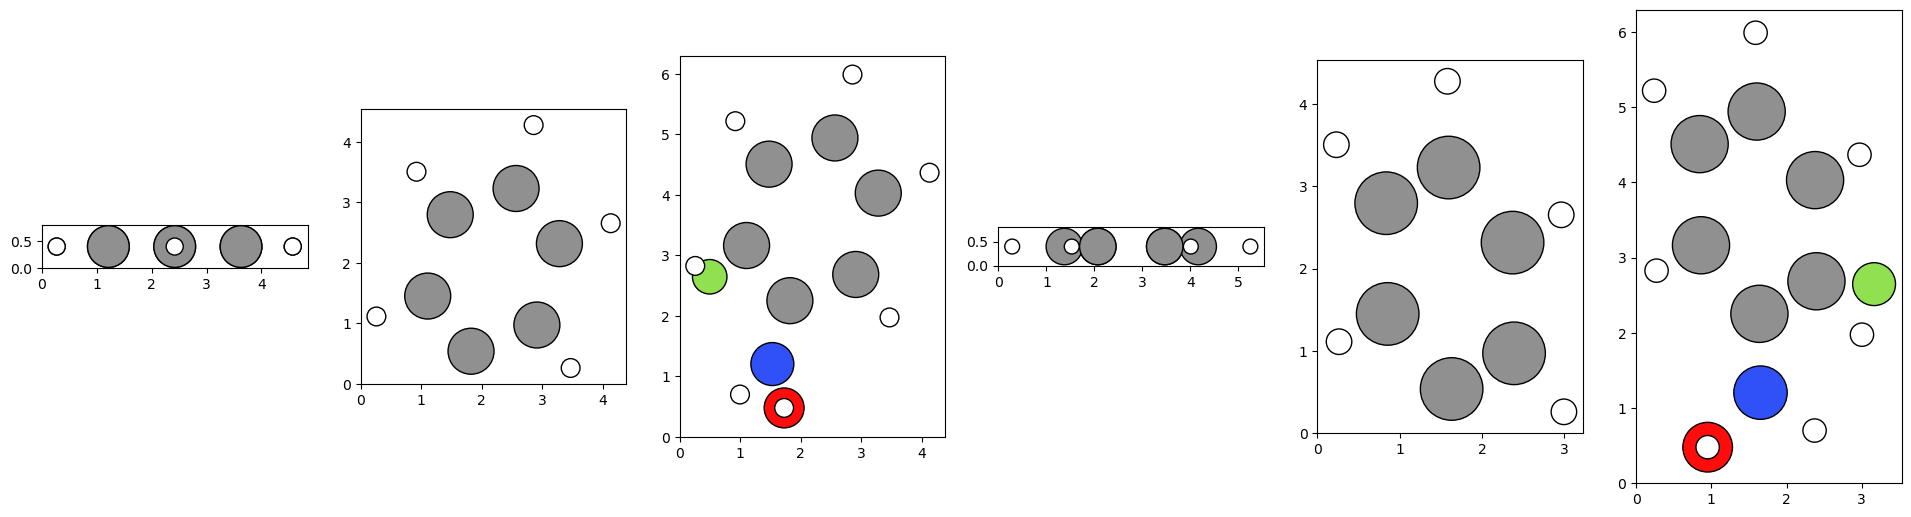

In [4]:
import numpy as np
import copy as cp

path = "/Users/adrianaladera/Desktop/MIT/research/MOChAs/prototype_structures/mithrene-amine/"
if os.path.exists("{}POSCAR.vasp".format(path)):
    os.rename("{}POSCAR.vasp".format(path), "{}POSCAR".format(path))
    print("changing to POSCAR")

ligma = molecule('C6H6')
benzene = molecule('C6H6')
ligma.rotate(420, 'x')
ligma.rotate(69, 'y')
ligma.rotate(66.6, '-z')
amine = molecule('NH2')

# print(ligma.get_chemical_symbols())
# ligma.pop()
# ligma.pop(5)


C_indices = np.array([5])
plane_indices = np.array([[32,48,16]])
cunt = 0
O_positions = []
num_O = 0
u_vecs, v_vecs = [], []
# for atom in ligand:
#     if atom.symbol == 'O':
u = plane_equation(ligma.get_positions()[0], ligma.get_positions()[2], ligma.get_positions()[4])
# print(ligma.get_positions()[0], ligma.get_positions()[2], ligma.get_positions()[4], u)
u_vecs.append(u[:-1])
O_positions.append(ligma.get_positions()[len(ligma)-1])
# O_positions.append(ligand.get_positions()[atom.index])
num_O += 1
cunt += 1

# for O in range(num_O):
#     ligand.pop()
ligma.pop()

ligno_O = cp.copy(ligma)
fig, ax = plt.subplots(1,6, figsize=(24,8))
plot_atoms(benzene, ax[0], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(ligno_O, ax[1], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(benzene, ax[3], radii=0.5, rotation=('90x,90y,0z'))
plot_atoms(ligno_O, ax[4], radii=0.5, rotation=('90x,90y,0z'))

cunt = 0
for C,O,u in zip(C_indices, O_positions, u_vecs):
    amine = molecule('NH2') # initially in the yz plane
    print(amine.get_chemical_symbols())
    amine_direction = Atoms('NH', [amine.get_positions()[0], amine.get_positions()[1]]) 
    U_vec = Atoms('CF', [ligma.get_positions()[5], ligma.get_positions()[6]])
    uv = get_components(ligma.get_positions()[5], ligma.get_positions()[6])
    H1_vec = get_components(amine.get_positions()[0], amine.get_positions()[1])
    H2_vec = get_components(amine.get_positions()[0], amine.get_positions()[2])
    amangle = get_angle(H1_vec, H2_vec)
    # print(H1_vec, H2_vec, amine.get_positions(), amangle)
    amine_direction.rotate(amangle/2.0, '-x') # angles are valid but apparently just don't look like it from the visualization
    H_vec = get_components(amine_direction.get_positions()[0], amine_direction.get_positions()[1])
    # uv = 
    U_vec.rotate(uv, u)
    # amine_direction.pop(0)
    U_dot = Atoms('F', [U_vec.get_positions()[1]])
    ligma.extend(U_dot)
    # amineCl = Atoms('Cl', [amine_direction.get_positions()[1]])
    # print(H1_vec, H2_vec, amine_direction.get_positions(), amangle)
    # amine.extend(amineCl)
#     amine.pop()

# fig, ax = plt.subplots(1, figsize=(24,8))
# plot_atoms(amine, ax, radii=0.5, rotation=('90x,90y,0z'))


    # IDEA:
    # - get angle between amines prior to rotating (easy because it's in plane with the x axis)
    # - find half angle and rotate H vector to be in the middle of the NH2 (at the half angle)
    # - use H vector to calculate the proper rotations between planes and shit
    # - whatever rotations applied to H should also be applied to the amine!
    # - hopefully this will get the amine to rotate fucking properly

    # # print(amine.get_positions())
    # # amine.rotate(180,'z', center=amine.get_positions()[0])
    v = get_components(ligma.get_positions()[C], O) # get angle between vector and plane
    # # print(amine.get_positions())
    # # H_plane = plane_equation(amine.get_positions()[0], amine.get_positions()[1], amine.get_positions()[2]) # rotate H until || with v vector
    # # H_vec = get_components(amine.get_positions()[0], amine.get_positions()[3])
    # H_vec = get_components(amine_direction.get_positions()[0], amine_direction.get_positions()[1])
    # theta = angle_between(H_vec, v)
    # if theta < 90.0:
    #     theta = 180.0 - theta
    # print(theta)
    # # # to rotate around a vector perpendicular to plane, just use plane coefficients
    # amine_direction.rotate(theta, u)
    temp = Atoms('O', [O]) #replace position
    # temp2 = Atoms('O',[amine_direction.get_positions()[1]])
    amine.rotate(H_vec, v)
    # amine.extend(temp)
    # amine.extend(temp2)
    # # print(ligma.get_chemical_symbols())
    # # C_vec = get_components(ligma.get_positions()[4], ligma.get_positions()[5])
    H1_vec = get_components(amine.get_positions()[0], amine.get_positions()[1])
    temp2 = Atoms('O',[amine.get_positions()[1]])
    amine.extend(temp2)
    sigma = get_plane_angle(u, H1_vec)
    # print(sigma)
    if sigma < 90:
        sigma = 180 - sigma
    # print(sigma)
    # # print(sigma)
    # # # # to rotate around a vector perpendicular to plane, just use plane coefficients
    amine.rotate(sigma, v)
    # # print(H_plane, v,theta, u)
    T = get_components(amine.get_positions()[0], O)
    amine.translate(T)
    
    ligma.extend(amine)
    cunt += 1

plot_atoms(ligma, ax[2], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(ligma, ax[5], radii=0.5, rotation=('90x,90y,0z'))
write("/Users/adrianaladera/Desktop/yourmom/ass.html", ligma)

## 

## Checking how the planes and vectors look in matplotlib (dormant)

(0.0, 0.806442, -0.637603) (0.0, -0.806442, -0.637603) [[ 0.        0.        0.14169 ]
 [ 0.        0.806442 -0.495913]
 [ 0.       -0.806442 -0.495913]] 103.33758782393065
(0.0, 0.806442, -0.637603) (0.0, -0.806442, -0.637603) [[ 0.          0.12102816  0.07367659]
 [ 0.         -0.00425959 -0.94671023]] 103.33758782393065
113.86032281617369


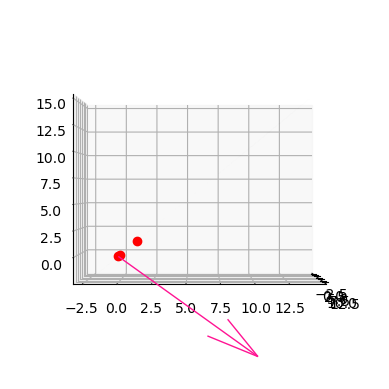

In [87]:
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

path = "/Users/adrianaladera/Desktop/MIT/research/MOChAs/prototype_structures/mithrene-amine/"
if os.path.exists("{}POSCAR.vasp".format(path)):
    os.rename("{}POSCAR.vasp".format(path), "{}POSCAR".format(path))
    print("changing to POSCAR")

ligma = molecule('C6H6')
benzene = molecule('C6H6')
ligma.rotate(47, 'x')
amine = molecule('NH2')

C_indices = np.array([5])
plane_indices = np.array([[32,48,16]])
O_positions = []
num_O = 0
u_vecs, v_vecs = [], []
u = plane_equation(ligma.get_positions()[0], ligma.get_positions()[2], ligma.get_positions()[4])
a,b,c,d = u[0],u[1],u[2], u[3]
u_vecs.append(u[:-1])
O_positions.append(ligma.get_positions()[len(ligma)-1])
num_O += 1
cunt += 1

# for O in range(num_O):
#     ligand.pop()
ligma.pop()

ligno_O = cp.copy(ligma)

cunt = 0
for C,O,u in zip(C_indices, O_positions, u_vecs):
    amine = molecule('NH2')
    amine_direction = Atoms('NH', [amine.get_positions()[0], amine.get_positions()[1]]) 
    H1_vec = get_components(amine.get_positions()[0], amine.get_positions()[1])
    H2_vec = get_components(amine.get_positions()[0], amine.get_positions()[2])
    amangle = get_angle(H1_vec, H2_vec)
    print(H1_vec, H2_vec, amine.get_positions(), amangle)
    amine_direction.rotate(amangle/2.0 + 7, '-x')
    amineH = Atoms('H', [amine_direction.get_positions()[1]])
    print(H1_vec, H2_vec, amine_direction.get_positions(), amangle)
    amine.extend(amineH)
#     amine.pop()

# fig, ax = plt.subplots(1, figsize=(24,8))
# plot_atoms(amine, ax, radii=0.5, rotation=('90x,90y,0z'))


    # IDEA:
    # - get angle between amines prior to rotating (easy because it's in plane with the x axis)
    # - find half angle and rotate H vector to be in the middle of the NH2 (at the half angle)
    # - use H vector to calculate the proper rotations between planes and shit
    # - whatever rotations applied to H should also be applied to the amine!
    # - hopefully this will get the amine to rotate fucking properly

    # print(amine.get_positions())
    # amine.rotate(180,'z', center=amine.get_positions()[0])
    v = get_components(O, ligma.get_positions()[C]) # get angle between vector and plane
    # print(amine.get_positions())
    # H_plane = plane_equation(amine.get_positions()[0], amine.get_positions()[1], amine.get_positions()[2]) # rotate H until || with v vector
    # H_vec = get_components(amine.get_positions()[0], amine.get_positions()[3])
    H_vec = get_components(amine_direction.get_positions()[0], amine_direction.get_positions()[1])
    theta = get_angle(H_vec, v)
    if theta < 90.0:
        theta = 180.0 - theta
    print(theta)
    # # to rotate around a vector perpendicular to plane, just use plane coefficients
    amine_direction.rotate(theta, u)
    # amine.rotate(theta, u)
    # print(ligma.get_chemical_symbols())
    # C_vec = get_components(ligma.get_positions()[4], ligma.get_positions()[5])
    # sigma = angle_between(H_vec, C_vec)
    # # if sigma < 90.0:
    # sigma = 180.0 - sigma
    # print(sigma)
    # # # to rotate around a vector perpendicular to plane, just use plane coefficients
    # amine.rotate(sigma, v)
    # print(H_plane, v,theta, u)
    T = get_components(amine.get_positions()[0], O)
    amine.translate(T)
    
    ligma.extend(amine)

    x = np.linspace(-2, 14, 5)
    y = np.linspace(-2, 14, 5)
    X, Y = np.meshgrid(x, y)

    Z = (d - a * X - b * Y) / c

    # plot the mesh. Each array is 2D, so we flatten them to 1D arrays
    ax.plot_surface(X, Y, Z)
    ax.plot(*zip(ligma.get_positions()[0], ligma.get_positions()[2], ligma.get_positions()[4]), color='r', linestyle=' ', marker='o')
    ax.quiver([ligma.get_positions()[2][0]], [ligma.get_positions()[2][1]], [ligma.get_positions()[2][2]], [u[0]], [u[1]], [u[2]], colors=['#FF1493'], length=3, linewidth=1)
    ax.view_init(0, 0)

    cunt += 1


plt.show()
# plot_atoms(ligma, ax[2], radii=0.5, rotation=('90x,180y,0z'))
# plot_atoms(ligma, ax[5], radii=0.5, rotation=('90x,90y,0z'))

# Trying to rotate vector 'a' into another vector 'v' 

In [189]:
# view(ligma, viewer='x3d')

## Same as above but with generalized functions and cleaner code

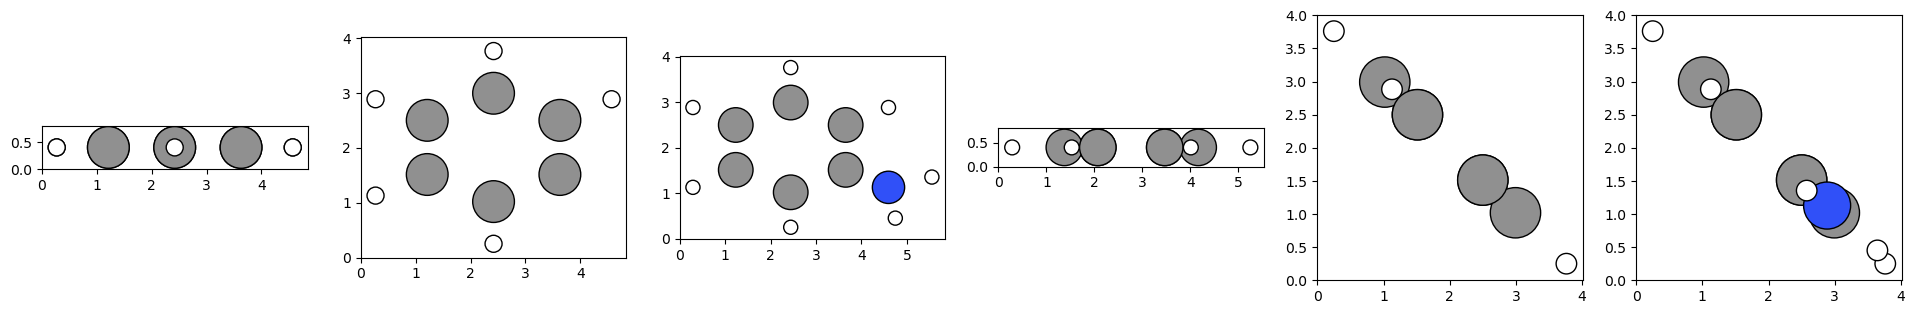

In [9]:
import numpy as np
import copy as cp

path = "/Users/adrianaladera/Desktop/MIT/research/MOChAs/prototype_structures/mithrene-amine/"
if os.path.exists("{}POSCAR.vasp".format(path)):
    os.rename("{}POSCAR.vasp".format(path), "{}POSCAR".format(path))
    print("changing to POSCAR")

ligma = molecule('C6H6')
benzene = molecule('C6H6')
ligma.rotate(45, 'x')

# ligma.rotate(126, '-z')
amine = molecule('NH2')

# print(ligma.get_chemical_symbols())
# ligma.pop()
# ligma.pop(5)


C_indices = np.array([5])
plane_indices = np.array([[32,48,16]])
cunt = 0
O_positions = []
num_O = 0
u_vecs, v_vecs = [], []
# for atom in ligand:
#     if atom.symbol == 'O':
u = plane_equation(ligma.get_positions()[0], ligma.get_positions()[2], ligma.get_positions()[4])
# print(ligma.get_positions()[0], ligma.get_positions()[2], ligma.get_positions()[4], u)
u_vecs.append(u[:-1])
O_positions.append(ligma.get_positions()[len(ligma)-1])
# O_positions.append(ligand.get_positions()[atom.index])
num_O += 1
cunt += 1

# for O in range(num_O):
#     ligand.pop()
ligma.pop()

ligno_O = cp.copy(ligma)
fig, ax = plt.subplots(1,6, figsize=(24,8))
plot_atoms(benzene, ax[0], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(ligno_O, ax[1], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(benzene, ax[3], radii=0.5, rotation=('90x,90y,0z'))
plot_atoms(ligno_O, ax[4], radii=0.5, rotation=('90x,90y,0z'))

cunt = 0
for C,O,u in zip(C_indices, O_positions, u_vecs):
    amine = molecule('NH2') # initially in the yz plane
    # print(amine.get_chemical_symbols())
    amine_direction = Atoms('NH', [amine.get_positions()[0], amine.get_positions()[1]]) 
    H1_vec = get_components(amine.get_positions()[0], amine.get_positions()[1])
    H2_vec = get_components(amine.get_positions()[0], amine.get_positions()[2])
    amangle = get_angle(H1_vec, H2_vec)
    amine_direction.rotate(amangle/2.0, '-x') # angles are valid but apparently just don't look like it from the visualization
    H_vec = get_components(amine_direction.get_positions()[0], amine_direction.get_positions()[1])
    v = get_components(ligma.get_positions()[C], O) # get angle between vector and plane
    amine.rotate(H_vec, v)
    H1_vec = get_components(amine.get_positions()[0], amine.get_positions()[1])
    sigma = get_plane_angle(u, H1_vec)
    if sigma < 90:
        sigma = 180 - sigma
    amine.rotate(sigma, v)
    T = get_components(amine.get_positions()[0], O)
    amine.translate(T)
    
    ligma.extend(amine)
    cunt += 1

plot_atoms(ligma, ax[2], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(ligma, ax[5], radii=0.5, rotation=('90x,90y,0z'))
write("/Users/adrianaladera/Desktop/yourmom/ass.html", ligma)

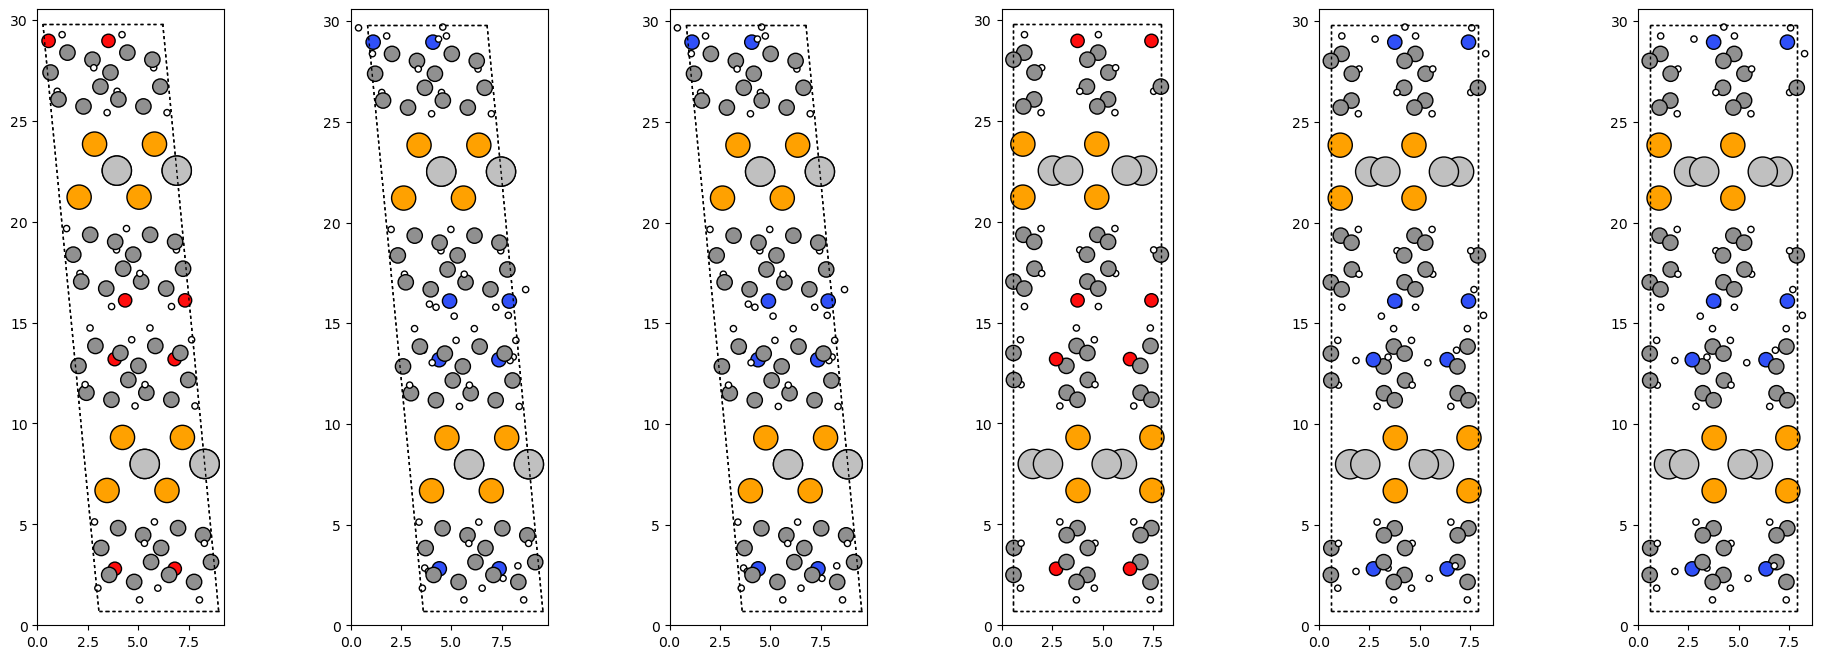

In [160]:
from ase.neighborlist import NeighborList
import math as meth
import numpy as np
import copy as cp

path = "/Users/adrianaladera/Desktop/yourmom/test/"
if os.path.exists("{}POSCAR_AgS-1195946-1815-1.res.vasp".format(path)):
    os.rename("{}POSCAR.vasp".format(path), "{}POSCAR".format(path))
    print("changing to POSCAR")

mithamine = read(f'{path}POSCAR') # is an atoms object so it can be modified!
mith_nomod = read(f'{path}POSCAR') # is an atoms object so it can be modified!
H = Atoms('H')
Cl = Atoms('Cl')

C_indices = np.array([32, 34, 36, 38, 49, 51, 53, 55])
plane_indices = np.array([[32,48,16],[34,50,18],[36,52,20],[38,54,22],[49,33,17],[51,35,19],[53,37,21],[55,39,23]])

cunt = 0
O_positions = []
num_O = 0
u_vecs, v_vecs = [], []
for atom in mithamine:
    if atom.symbol == 'O':
        # print(vec, C_indices[cunt], atom.index)
        # vec = get_components(mithamine.get_positions()[C_indices[cunt]], mithamine.get_positions()[atom.index])
        u = plane_equation(mithamine.get_positions()[plane_indices[cunt][0]], mithamine.get_positions()[plane_indices[cunt][1]], mithamine.get_positions()[plane_indices[cunt][2]])
        # print(vec, vec[:-1])
        u_vecs.append(u[:-1])
        O_positions.append(mithamine.get_positions()[atom.index])
        num_O += 1
        cunt += 1

for O in range(num_O):
    mithamine.pop()

mithno_O = cp.copy(mithamine)

cunt = 0
for C,O,u in zip(C_indices, O_positions, u_vecs):
    amine = molecule('NH2') # initially in the yz plane
    # print(amine.get_chemical_symbols())
    amine_direction = Atoms('NH', [amine.get_positions()[0], amine.get_positions()[1]]) 
    H1_vec = get_components(amine.get_positions()[0], amine.get_positions()[1])
    H2_vec = get_components(amine.get_positions()[0], amine.get_positions()[2])
    amangle = get_angle(H1_vec, H2_vec)
    amine_direction.rotate(amangle/2.0, '-x') # angles are valid but apparently just don't look like it from the visualization
    H_vec = get_components(amine_direction.get_positions()[0], amine_direction.get_positions()[1])
    v = get_components(mithamine.get_positions()[C], O) # get angle between vector and plane

    amine.rotate(H_vec, v)
    H1_vec = get_components(amine.get_positions()[0], amine.get_positions()[1])
    sigma = get_plane_angle(u, H1_vec)
    if sigma < 90:
        sigma = 180 - sigma
    # amine.rotate(sigma, v)
    T = get_components(amine.get_positions()[0], O)
    amine.translate(T)
    
    mithamine.extend(amine)
    cunt += 1

fig, ax = plt.subplots(1,6, figsize=(24,8))
plot_atoms(mith_nomod, ax[0], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(mithno_O, ax[1], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(mithamine, ax[2], radii=0.5, rotation=('90x,180y,0z'))
plot_atoms(mith_nomod, ax[3], radii=0.5, rotation=('90x,90y,0z'))
plot_atoms(mithno_O, ax[4], radii=0.5, rotation=('90x,90y,0z'))
plot_atoms(mithamine, ax[5], radii=0.5, rotation=('90x,90y,0z'))

write(f"{path}mithrene-amine.vasp", mithamine)